## Quickstart  

**Last Modified**: February 10, 2025  

This notebook outlines the machine learning pipeline for implementing the methods proposed in [Agarwal et al. (2024)](https://www.biorxiv.org/content/10.1101/2024.12.28.630628v1). The code is demonstrated on a dummy dataset, and the data is expected to be stored in the following format:  

- root directory
  - individual 1
    - 2022.csv
    - 2023.csv
    - 2024.csv
  - individual 2
    - 2022.csv
    - 2023.csv
  - individual 3
    - 2023.csv
    - 2024.csv

**Note**: Individual name cannot contain an ``undercsore`` ($\_$).

Each acceleration data CSV is expected to have columns 
| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| UTC Date[mm/dd]                 | string    | date in format mm/dd                             |
| UTC DateTime                    | string    | time in format HH:MM:SS                          |
| Milliseconds                    | int       | milliseconds (three digits)                      |
| Acc X [g]                       | float     | acceleration reading along X axis                |
| Acc Y [g]                       | float     | acceleration reading along Y axis                |
| Acc Z [g]                       | float     | acceleration reading along Z axis                |
| Temperature [Celsius]           | float     | temperature reading in celsius                   |


The behavior annotations are expected to be a CSV file with columns 
| Column Name           | Data Type | Description                                           |
|-----------------------|-----------|-------------------------------------------------------|
| id                    | string    | individual identification                             |
| Behavior              | string    | behavior label                                        |
| Timestamp_start       | string    | start time of the behavior in format %Y/%m/%d %H:%M:%S|
| Timestamp_end         | string    | end time of the behavior in format %Y/%m/%d %H:%M:%S  |
| Source                | string    | source of behavior label (eg. audio/video)            |

Before running this notebook, make sure to edit the `config/settings.py` file. Instructions for what each variable specifies are included in the script.


In [1]:

import sys
import os
import pandas as pd
import numpy as np
import torch
import torch
import time
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder
sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

In [22]:
import config as config
from scripts.matching import match_behaviors
import src.data_prep.create_segments_and_metadata as create_segments_and_metadata
import src.data_prep.data_prep_utils as data_prep_utils
import src.data_prep.create_matched_data_objects as create_matched_data_objects
import src.utils.data as utils_data
import src.utils.io as utils_io
import src.utils.plot as utils_plot
from src.methods.prediction_model import create_dynamic_conv_model
from src.utils.train import (training_loop,
                             multi_label_eval_loop)

In [25]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 40
mpl.rcParams['legend.fontsize'] = 40
mpl.rcParams['axes.titlesize'] = 40
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

## 0. Create Dummy Data

We create dummy acceleration and annotations data. We consider five behavioral categories of interest: 
 - Feeding
 - Resting
 - Moving
 - Running
 - Vigilant

Let the tri-axial acceleration at time $t$ for behavior $a$ be denoted by $(X_t^a, Y_t^a, Z_t^a)$. We suppose that the distribution of tri-axial acceleration is
$$(X_t^a, Y_t^a, Z_t^a) \sim C_a + \text{Unif(-2, 2)}$$
where $C_a$ is a constant unique to each behavior and assumed to have the following values. Further, we assume the following class distribution for the behaviors of interest.
| Behavior | $C_a$ | Probability of occurence |
|----------|-------|--------------------------|
| Feeding  | 3.0   | 0.05   |
| Resting  | 0.0   | 0.5 |
| Moving   | 2.0   | 0.2 |
| Running  | 4.0   | 0.05 |
| Vigilant | 1.0   | 0.2 |




In [4]:
# Define individuals and years of dataset available for them
individuals = {"individual1": [2022, 2023, 2024],
               "individual2": [2022, 2023],
               "individual3": [2023, 2024]}

# Create directories and generate acceleration data
os.makedirs(config.TEST_ROOT_DIR, exist_ok=True)

test_behavior_prob = [0.05, 0.5, 0.2, 0.05, 0.2]
behavior_magnitudes = [3.0, 0.0, 2.0, 4.0, 1.0]
behavior_modifiers = {behavior:constant for behavior, constant in zip(config.BEHAVIORS, behavior_magnitudes)}

print("CLASS DISTRIBUTION")
for b, p in zip(config.BEHAVIORS, test_behavior_prob):
    print(f"{b:<10}: {p}")

CLASS DISTRIBUTION
Feeding   : 0.05
Resting   : 0.5
Moving    : 0.2
Running   : 0.05
Vigilant  : 0.2


In [97]:
behavior_data = []

# generate random accelerometry data for i day
for individual, years in individuals.items():
    individual_dir = config.TEST_PATHS[individual]
    os.makedirs(individual_dir, exist_ok=True)
    
    for year in years:
        start_time = datetime(year, 1, 1)
        end_time = datetime(year, 1, 1, 23, 59, 59)
        current_time = start_time
        time_delta = timedelta(seconds=1/config.SAMPLING_RATE)
        
        timestamps = []
        while current_time <= end_time:
            timestamps.append(current_time)
            current_time += time_delta
        
        data = {
            "UTC Date[mm/dd]": [t.strftime("%m/%d") for t in timestamps],
            "UTC DateTime": [t.strftime("%H:%M:%S") for t in timestamps],
            "Milliseconds": [t.microsecond // 1000 for t in timestamps],
            "Acc X [g]": np.random.uniform(-2, 2, len(timestamps)),
            "Acc Y [g]": np.random.uniform(-2, 2, len(timestamps)),
            "Acc Z [g]": np.random.uniform(-2, 2, len(timestamps)),
            "Temperature [Celsius]": np.random.uniform(20, 30, len(timestamps))
        }
        
        df = pd.DataFrame(data)

        num_behaviors = np.random.randint(10, 20)
        for _ in range(num_behaviors):
            behavior_start = start_time + timedelta(hours=np.random.randint(0, 24), 
                                                    minutes=np.random.randint(0, 60),
                                                    seconds=np.random.randint(5, 120))
            behavior_end = behavior_start + timedelta(minutes=np.random.randint(0, 1),
                                                        seconds=np.random.randint(5, 120))

            if behavior_end > end_time:
                behavior_end = end_time
            
            observed_behavior = np.random.choice(a=config.BEHAVIORS,
                                                    p=test_behavior_prob)
            behavior_data.append([individual, 
                                observed_behavior, 
                                behavior_start.strftime("%Y/%m/%d %H:%M:%S"),
                                behavior_end.strftime("%Y/%m/%d %H:%M:%S"),
                                "Video"])
            
            # Modify the acceleration values based on behavior
            df_full_timestamp = pd.to_datetime(str(year) + "/" + df["UTC Date[mm/dd]"] + " " + df["UTC DateTime"], format="%Y/%m/%d %H:%M:%S")
            mask = (df_full_timestamp >= pd.to_datetime(behavior_start, format="%Y/%m/%d %H:%M:%S")) & \
                   (df_full_timestamp <= pd.to_datetime(behavior_end, format="%Y/%m/%d %H:%M:%S"))
            if observed_behavior in behavior_modifiers:
                            df.loc[mask, ["Acc X [g]", "Acc Y [g]", "Acc Z [g]"]] += behavior_modifiers[observed_behavior]



        df.to_csv(os.path.join(individual_dir, f"{year}.csv"), index=False)

annotations_df = pd.DataFrame(behavior_data, 
                                columns=["id", "Behavior", "Timestamp_start", "Timestamp_end", "Source"])

annotations_df.to_csv(config.TEST_ANNOTATIONS_PATH, index=False)


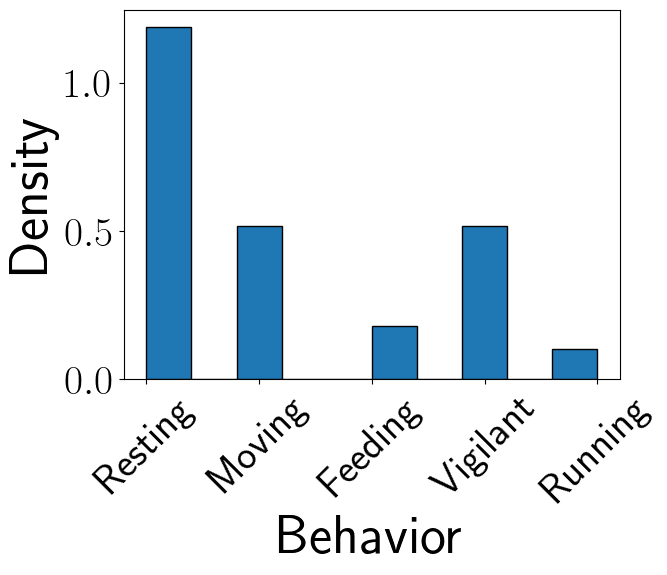

In [5]:
annotations_df = pd.read_csv(config.TEST_ANNOTATIONS_PATH)
plt.hist(annotations_df['Behavior'], edgecolor='black', density=True)
plt.xticks(rotation=45) 
plt.xlabel("Behavior")  # Label x-axis
plt.ylabel("Density")  # Label y-axis
plt.show()

## 1 Creating Data Objects

#### 1.1 Create segments by reading accelerometry CSV in chunks

For reading the CSV files, organized in the format decsribed above, we run the following function. `run_vectronics` creates segments by reading accelerometer data in chunks and saves the half-day segments in a 
directory titled `combined_acc` inside the data directory of each individual.

**Parameters:**
- **path_mappings** (dict): A dictionary where keys are individual names (str) and values are file paths (str) to their data directories.
- **max_chunks** (int, optional): The maximum number of chunks to process per individual. Default is 0 (no limit).

The half-day chunks are saved with two extra columns:
| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| Timestamp                       | string    | complete timestamp in format `%m/%d/%Y %H:%M:%S` |
| date_am_pm_id                   | string    | half day timestampe in format `%m/%d/%Y_%P`      |


In [98]:
create_segments_and_metadata.run_vectronics(config.TEST_PATHS, max_chunks=5)

Processing individual:         individual1
Files for this individual :    ['2023.csv', '2022.csv', '2024.csv']
Handling the csv:              /Users/medha/Documents/GitHub/AWD-Biologging/test/individual1/2023.csv
Number of half days in chunk:  2
2023-01-01_AM
2023-01-01_PM
Number of half days in chunk:  1
2023-01-01_PM
Handling the csv:              /Users/medha/Documents/GitHub/AWD-Biologging/test/individual1/2022.csv
Number of half days in chunk:  2
2022-01-01_AM
2022-01-01_PM
Number of half days in chunk:  1
2022-01-01_PM
Handling the csv:              /Users/medha/Documents/GitHub/AWD-Biologging/test/individual1/2024.csv
Number of half days in chunk:  2
2024-01-01_AM
2024-01-01_PM
Number of half days in chunk:  1
2024-01-01_PM

Processing individual:         individual2
Files for this individual :    ['2023.csv', '2022.csv']
Handling the csv:              /Users/medha/Documents/GitHub/AWD-Biologging/test/individual2/2023.csv
Number of half days in chunk:  2
2023-01-01_AM
2023-01-01

#### 1.2 Create metadata

The function `create-metadata` generates metadata for the saved half-day segments of accelerometer data. Since a total of 7 days of data is available for the dummy data, we have 14 half days of data. A summary of these 14 half days is saved in the metadata file.

**Parameters:**
- **path_mappings** (dict): A dictionary where keys are individual names (str) and values are file paths (str) to their data directories.
- **metadata_path** (str): The file path where the generated metadata CSV file will be saved.

**Metadata columns:**
| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| file path                       | string    | Path-like object of where the half-day segment is stored |
| individual ID                   | string    | Unique identifier for an individual             |
| year                            | int       | Year of behavior observation                    |
| UTC Date [yyyy-mm-dd]           | string    | Date of behavior observation                    |
| am/pm                           | string    | AM or PM time of behavior observation           |
| half day [yyyy-mm-dd_am/pm]     | string    | Half-day of behavior observation                |
| avg temperature [C]             | float     | Average temperature on the half-day of behavior observation |


In [99]:
create_segments_and_metadata.create_metadata(config.TEST_PATHS, config.TEST_METADATA_PATH)

individual individual1 has 6 halfdays.


100%|██████████| 6/6 [00:28<00:00,  4.79s/it]


individual individual2 has 4 halfdays.


100%|██████████| 4/4 [00:19<00:00,  4.85s/it]


individual individual3 has 4 halfdays.


100%|██████████| 4/4 [00:19<00:00,  4.87s/it]


In [100]:
metadata = pd.read_csv(config.TEST_METADATA_PATH)
metadata.head()

,file path,individual ID,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C]
0,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,AM,2023-01-01_AM,25.001343
1,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2024,2024-01-01,AM,2024-01-01_AM,24.999530
2,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2022,2022-01-01,AM,2022-01-01_AM,24.997830
3,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2024,2024-01-01,PM,2024-01-01_PM,25.002177
4,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,PM,2023-01-01_PM,25.002902


#### 1.3 Match the accelerometry segments with available annotations

Here we use the function `combined_annotations` to combine the video and audio annotations in a shared format. We cal also read the pre-ready annotations file. The annotations are expected to have follwoing columns.

**Annotations columns:**
| Column Name                     | Data Type | Description                                           |
|---------------------------------|-----------|-------------------------------------------------------|
| id                              | string    | individual identification                             |
| Behavior                        | string    | behavior label                                        |
| Timestamp_start                 | string    | start time of the behavior in format %Y/%m/%d %H:%M:%S|
| Timestamp_end                   | string    | end time of the behavior in format %Y/%m/%d %H:%M:%S  |
| Source                          | string    | source of annotation (eg. video/audio)                |

In [6]:
# specify the expected format for annotations, add instructions for loading these annotations.

all_annotations = pd.read_csv(config.TEST_ANNOTATIONS_PATH)
all_annotations.head()

,id,Behavior,Timestamp_start,Timestamp_end,Source
0,individual1,Resting,2022/01/01 06:27:22,2022/01/01 06:28:24,Video
1,individual1,Resting,2022/01/01 04:23:06,2022/01/01 04:23:41,Video
2,individual1,Moving,2022/01/01 08:44:36,2022/01/01 08:45:12,Video
3,individual1,Feeding,2022/01/01 03:18:45,2022/01/01 03:20:35,Video
4,individual1,Vigilant,2022/01/01 07:55:26,2022/01/01 07:55:53,Video


#### 1.4 Match annotations and acceleration data

The function `create_matched_data` matches the files in metadata with available annotations (both in formats discussed above).

**Arguments:**
filtered_metadata: pandas dataframe with columns ['file path', 'individual ID', 'year', 'UTC Date [yyyy-mm-dd]', 'am/pm', 'half day [yyyy-mm-dd_am/pm]', 'avg temperature [C]']
annotations: pandas dataframe with columns ['id', 'Behavior', 'Timestamp_start', 'Timestamp_end', 'Source']

**Returns**:

acc_summary: pandas dataframe = summary of the matched acceleration files with columns 

| Column Name            | Data Type | Description                                           |
|------------------------|-----------|-------------------------------------------------------|
| id                     | string    | individual indentification                            |
| date_am_pm_id          | string    | half day description in format yyyy-mm-dd_{am/pm}     |
| annotations            | string    | behavior label                                        |
| acc                    | float     | matched acceleration duration                         |
| number of matched acc  | int       | number of matched annotations in the half day         |

acc_data: pandas dataframe = final matched windows of acc data  with columns

| Column Name            | Data Type | Description                                           |
|------------------------|-----------|-------------------------------------------------------|
| individual ID          | string    | individual indentification                            |
| behavior               | string    | behavior label                                        |
| behavior_start         | float     |start time in format %Y/%m/%d %H:%M:%S                 |
| behavior_end           | float     |end time in format %Y/%m/%d %H:%M:%S                   |
| duration               | float     |duration of the matched behavior                       |
| year                   | int       |year of behavior observation                           |
| UTC Date [yyyy-mm-dd]  | string    |date of behavior observation                           |
| am/pm                  | string    |date of behavior observation                           |
| half day [yyyy-mm-dd_am/pm] | string    |half day of behavior observation                  |
| avg temperature [C]    | string    |date of behavior observation                           |
| acc_x                  | list object| acceleration data along X axis                       |
| acc_y                  | list object| acceleration data along Y axis                       |
| acc_z                  | list object| acceleration data along Z axis                       |
| Source                 | string     | source of behavior annotation (video, audio, etc)    |

acc_data_metadata: pandas dataframe = metadata of the acceleration segments matched with annotations

| Column Name                     | Data Type | Description                                      |
|---------------------------------|-----------|--------------------------------------------------|
| file path                       | string    | Path-like object of where the half-day segment is stored |
| individual ID                   | string    | Unique identifier for an individual             |
| year                            | int       | Year of behavior observation                    |
| UTC Date [yyyy-mm-dd]           | string    | Date of behavior observation                    |
| am/pm                           | string    | AM or PM time of behavior observation           |
| half day [yyyy-mm-dd_am/pm]     | string    | Half-day of behavior observation                |
| avg temperature [C]             | float     | Average temperature on the half-day of behavior observation |


In [102]:
acc_summary, acc_data, acc_data_metadata = create_matched_data_objects.create_matched_data(metadata, all_annotations)

individual individual1 has 6 halfdays in the filtered metadata.


Processing unique half days for individual1: 100%|██████████| 6/6 [00:35<00:00,  5.90s/it]


individual individual2 has 4 halfdays in the filtered metadata.


Processing unique half days for individual2: 100%|██████████| 4/4 [00:23<00:00,  5.81s/it]


individual individual3 has 4 halfdays in the filtered metadata.


Processing unique half days for individual3: 100%|██████████| 4/4 [00:23<00:00,  5.97s/it]


In [103]:
# save the matched data objects 

acc_summary.to_csv(utils_io.get_test_matched_summary_path())
acc_data.to_csv(utils_io.get_test_matched_data_path())
acc_data_metadata.to_csv(utils_io.get_test_matched_metadata_path())

In [7]:
# load the saved matched data objects 

acc_summary = pd.read_csv(utils_io.get_test_matched_summary_path())
acc_data = pd.read_csv(utils_io.get_test_matched_data_path())
acc_data_metadata = pd.read_csv(utils_io.get_test_matched_metadata_path())

In [8]:
# view acc_summary, acc_data, acc_data_metadata
acc_summary.head()

,Unnamed: 0,id,date_am_pm_id,annotations,acc,number of matched acc
0,0,individual1,2023-01-01_AM,14,14.0,1
1,1,individual1,2023-01-01_AM,36,36.0,1
2,2,individual1,2023-01-01_AM,12,12.0,1
3,3,individual1,2023-01-01_AM,27,27.0,1
4,4,individual1,2023-01-01_AM,88,88.0,1


In [9]:
acc_data.head()

,Unnamed: 0,individual ID,behavior,behavior_start,behavior_end,duration,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C],acc_x,acc_y,acc_z,Source
0,0,individual1,Resting,2023-01-01 04:10:09+00:00,2023-01-01 04:10:23+00:00,14.0,2023,2023-01-01,AM,2023-01-01_AM,25.001343,"[-1.9766906727311944, -0.5024473944767842, 0.8...","[-1.539483869146609, -1.7987055910265553, -1.3...","[-1.901221555378357, 0.2679906267644858, 1.583...",Video
1,1,individual1,Moving,2023-01-01 11:06:44+00:00,2023-01-01 11:07:20+00:00,36.0,2023,2023-01-01,AM,2023-01-01_AM,25.001343,"[-1.7965376324331226, -0.224663472415838, -1.3...","[0.6266742135550745, 1.2395354507369096, 0.221...","[-0.5461380534232512, -0.1611585858375033, -1....",Video
2,2,individual1,Resting,2023-01-01 01:26:52+00:00,2023-01-01 01:27:04+00:00,12.0,2023,2023-01-01,AM,2023-01-01_AM,25.001343,"[1.052790607996104, 0.5706882113669374, -1.651...","[-0.0687548081432005, -1.6200152618645496, 1.4...","[-1.541620004692494, -0.1942523608574542, 1.92...",Video
3,3,individual1,Feeding,2023-01-01 06:42:49+00:00,2023-01-01 06:43:16+00:00,27.0,2023,2023-01-01,AM,2023-01-01_AM,25.001343,"[-0.6039585483168302, 0.977914975049806, 2.320...","[-0.8213292596024835, 0.936695547380344, 3.641...","[1.3366965400655233, 1.7771210420357848, 1.428...",Video
4,4,individual1,Running,2023-01-01 03:56:16+00:00,2023-01-01 03:57:44+00:00,88.0,2023,2023-01-01,AM,2023-01-01_AM,25.001343,"[1.3393590183918036, -1.950358291195259, 4.969...","[1.5203133949665513, -0.6080862100516704, 5.78...","[0.9036821003421394, -1.4636382696570358, 4.42...",Video


In [10]:
acc_data_metadata.head()

,Unnamed: 0,file path,individual ID,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C]
0,0,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,AM,2023-01-01_AM,25.001343
1,1,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,AM,2023-01-01_AM,25.001343
2,2,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,AM,2023-01-01_AM,25.001343
3,3,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,AM,2023-01-01_AM,25.001343
4,4,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,AM,2023-01-01_AM,25.001343


## 2. Training a Classification Model  

### 2.1 Creating Metadata Filters for Train and Test Data  

Metadata filters are dictionary objects where the keys correspond to all metadata columns except `file_path`. The values associated with each key are list-like objects specifying the values to be included in the filter. If a key has a value of `None`, it indicates no filtering based on that column.  

Below is an example metadata filter for an interdog experiment:  

```
{
    'dog ID': ['jessie', 'palus', 'ash', 'fossey'],
    'year': None,
    'UTC Date [yyyy-mm-dd]': None,
    'am/pm': None,
    'half day [yyyy-mm-dd_am/pm]': None,
    'avg temperature [C]': None
}
```


Make sure to edit the function `get_exp_filter_profiles` to describe the train-test splits


In [11]:
train_filter_profile, test_filter_profile = utils_data.get_exp_filter_profiles('no_split')
print('NO SPLIT')
print(f"{'train filter':<15} {train_filter_profile}")
print(f"{'test filter':<15} {test_filter_profile}")

print('\n')

train_filter_profile, test_filter_profile = utils_data.get_exp_filter_profiles('interdog')
print('INTERDOG')
print(f"{'train filter':<15} {train_filter_profile}")
print(f"{'test filter':<15} {test_filter_profile}")

NO SPLIT
train filter    {'individual ID': None, 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}
test filter     {'individual ID': None, 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}


INTERDOG
train filter    {'individual ID': ['jessie', 'palus', 'ash', 'fossey'], 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}
test filter     {'individual ID': ['green'], 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}


In [12]:
# load metadata
metadata = pd.read_csv(config.TEST_METADATA_PATH)
metadata.head()

,file path,individual ID,year,UTC Date [yyyy-mm-dd],am/pm,half day [yyyy-mm-dd_am/pm],avg temperature [C]
0,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,AM,2023-01-01_AM,25.001343
1,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2024,2024-01-01,AM,2024-01-01_AM,24.999530
2,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2022,2022-01-01,AM,2022-01-01_AM,24.997830
3,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2024,2024-01-01,PM,2024-01-01_PM,25.002177
4,/Users/medha/Documents/GitHub/AWD-Biologging/t...,individual1,2023,2023-01-01,PM,2023-01-01_PM,25.002902


In [13]:
# load annotations
all_annotations = pd.read_csv(config.TEST_ANNOTATIONS_PATH)
all_annotations.head()

,id,Behavior,Timestamp_start,Timestamp_end,Source
0,individual1,Resting,2022/01/01 06:27:22,2022/01/01 06:28:24,Video
1,individual1,Resting,2022/01/01 04:23:06,2022/01/01 04:23:41,Video
2,individual1,Moving,2022/01/01 08:44:36,2022/01/01 08:45:12,Video
3,individual1,Feeding,2022/01/01 03:18:45,2022/01/01 03:20:35,Video
4,individual1,Vigilant,2022/01/01 07:55:26,2022/01/01 07:55:53,Video


The training arguments, like details on the architecturee of the CNN based model, are specified using the following data class. Here is the description of all arguments.

| Argument Name                   | Data Type     | Description                                      |
|---------------------------------|---------------|--------------------------------------------------|
| experiment_name                 | string        | types of train-test splits           |
| batch_size                      | int           | batch size for minibatch training                          |
| window_duration_percentile      | float         | percentile of window duration for creating fixed duration segments    |
| train_test_split                | float         | proportion of data points in test set |
| train_val_split                 | float         | proportion of data points in validation set |
| padding                         | string        | padding type between "repeat" and "zeros" for segments shorter than chosen fixed window duration |
| theta                           | float         | degree of resampling for class rebalancing         |
| filter_type                     | string        | between "high" or "low" for bandpass filtering                   |
| cutoff_frequency                | float         | cutoff frequency for bandpass filetring     |
| cutoff_order                    | int           | order of bandpass cutoff |
| normalization                   | int           | boolean for whethere the data should be normalized, default = 0 |
| match                           | int           | boolean for whether to match the acc data with annotations if matched objects already found|
| min_duration                    | float         | minimum duration of fixed acc segments |
| n_CNNlayers                     | int           | number of CNN layers |
| n_channels                      | int           | number of output channels in the first CNN layers. They grow by a factor of 2 with each new layer |
| kernel_size                     | int           | kernel size for convolution layers |
| learning_rate                   | float         | learning rate for Adam optimizer |
| weight_decay                    | float         | weight decay parameter for Adam optimizer |
| num_epochs                      | int           | number of training epochs |
| alpha                           | float         | coverage for RAPS is 1-alpha |



In [14]:
from dataclasses import dataclass
import src.utils as utils
@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=20, 
    train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.8, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=2, n_channels=32, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=100, alpha=0.05
)


Create train and test splits based on the experimental split of choice. Create dataloaders for the datasets. The fnunction `setup_data_objects` create the 

**Arguments**:

| Column Name                     | Data Type        | Description                                      |
|---------------------------------|------------------|--------------------------------------------------|
| metadata                        | Pandas Dataframe | metadata of all acceleration segments            |
| all_annotations                 | Pandas Dataframe | available annotations                            |
| collapse_behavior_mapping       | dictionary       | mapping from fine to coarse behavior classes     |
| behaviors                       | list             | list of behaviors of interest for classification |
| args                            | dictionary       | training arguments                               |
| match                           | bool             | whether to match behaviors or use a pre-saved dataframe   |

**Returns**:


| Column Name | Data Type            | Description                                                                           |
|-------------|----------------------|---------------------------------------------------------------------------------------|
| X_train     | (n, d, T) np ndarray | train acceleration, n = no. of samples, d = no. of features, T = time axis            |
| y_train     | (n, K) np ndarray    | train labels, n = no. of samples, K = one-hot vector for the K classes behavior label |
| z_train     | pandas dataframe     | metadata associated with the train observations                                       |
| X_val       | (n, d, T) np ndarray | val   acceleration, n = no. of samples, d = no. of features, T = time axis            |
| y_val       | (n, K) np ndarray    | val labels, n = no. of samples, K = one-hot vector for the K classes behavior label   |
| z_val       | pandas dataframe     | metadata associated with the validation observations                                  |
| X_test      | (n, d, T) np ndarray | test acceleration, n = no. of samples, d = no. of features, T = time axis             |
| y_test      | (n, K) np ndarray    | test labels, n = no. of samples, K = one-hot vector for the K classes behavior label  |
| z_test      | pandas dataframe     | metadata associated with the test observations                                        |

We also create the train, validation, and test dataloaders using the `arc.utils.data.setup_multilabel_dataloaders` method.
 

In [15]:
start = time.time()
X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, _ = utils_data.setup_data_objects(metadata=metadata, 
                                                                                                    all_annotations=all_annotations, 
                                                                                                    collapse_behavior_mapping=config.COLLAPSE_BEHAVIORS_MAPPING, 
                                                                                                    behaviors=config.BEHAVIORS, 
                                                                                                    args=args, 
                                                                                                    reuse_behaviors=config.BEHAVIORS,
                                                                                                    acc_data_path=utils_io.get_test_matched_data_path(),
                                                                                                    acc_metadata_path=utils_io.get_test_matched_metadata_path()
                                                                                                    )

print("Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_train, return_counts=True)[1]))
print("")

n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(np.concatenate((y_train, y_val, y_test))))
train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)
time_diff = time.time() - start

print("")
print(f'Creating data objects takes {time_diff:.2f} seconds.')
print("")
print('Shape of dataframes')
print("==========================")
print(f"Train: -- X: {train_dataloader.dataset.tensors[0].shape}, Y: {train_dataloader.dataset.tensors[1].shape}, Z: {z_train.shape}")
print(f"Val: -- X: {val_dataloader.dataset.tensors[0].shape}, Y: {val_dataloader.dataset.tensors[1].shape}, Z: {z_val.shape}")
print(f"Test: -- X: {test_dataloader.dataset.tensors[0].shape}, Y: {test_dataloader.dataset.tensors[1].shape}, Z: {z_test.shape}")


Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 97
Before overlap, 
no. of train observations: 97, no. of test observations: 97
Overlapping indices of shape = (97,)
After removing overlaps, 
no. of train observations: 77, no. of test observations: 20

Matching annotations to acceleration snippets takes 4.267591 seconds


/Users/medha/Documents/GitHub/AWD-Biologging/notebooks/../src/utils/data.py:314: UserWarning: train and test filters overlap
  warnings.warn("train and test filters overlap", UserWarning)


Creating fixed-duration windows takes 0.581525 seconds.

Time series duration window = 27.0
Class distribution
     0
0   40
1  125
2  278
3   15
4  110


Creating data objects takes 4.87 seconds.

Shape of dataframes
Train: -- X: torch.Size([568, 3, 432]), Y: torch.Size([568, 5]), Z: (568, 7)
Val: -- X: torch.Size([142, 3, 432]), Y: torch.Size([142, 5]), Z: (142, 7)
Test: -- X: torch.Size([179, 3, 432]), Y: torch.Size([179, 5]), Z: (179, 7)


Now we plot a sample raw acceleration segment for all behaviors at random.

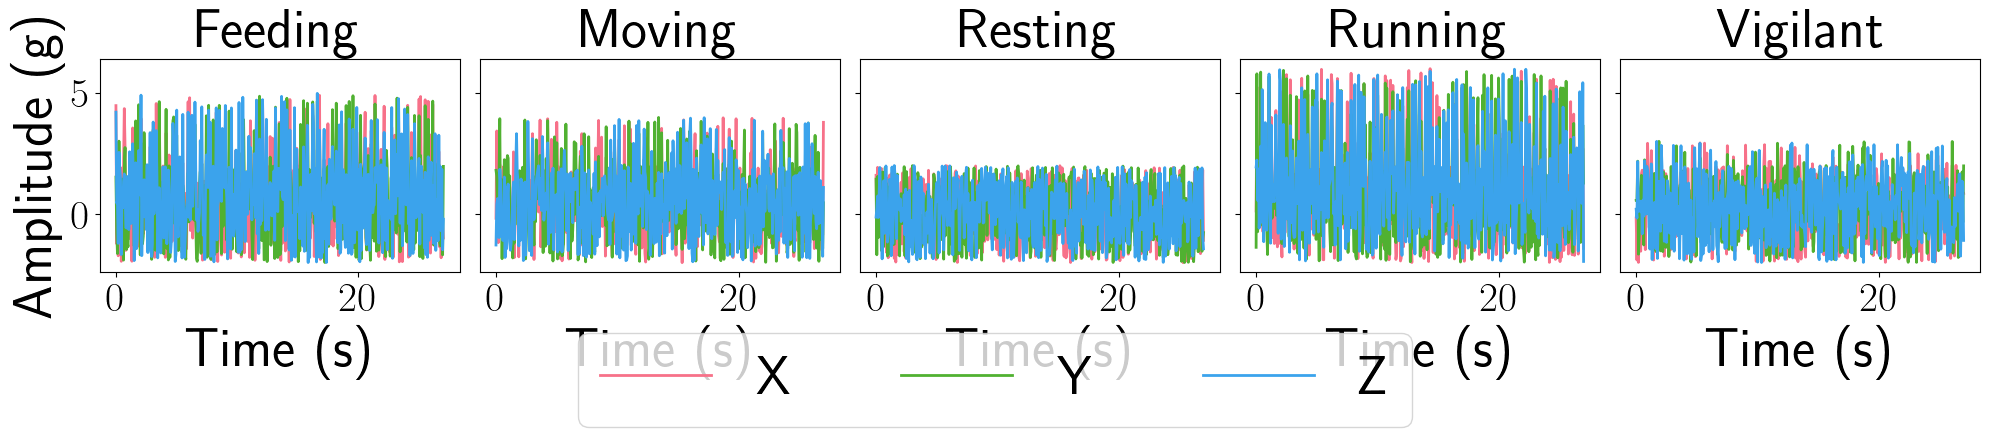

In [16]:
## fit a label encoder

label_encoder = LabelEncoder()
label_encoder.fit(config.BEHAVIORS)
utils_plot.plot_raw_time_series(X_train, label_encoder.inverse_transform(y_train))

In [18]:
#########################################
#### Model, loss, and optimizer
#########################################

device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# Define the sequential model
model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                    num_conv_layers=args.n_CNNlayers, 
                                    base_channels=args.n_channels, 
                                    kernel_size=args.kernel_size).to(device)

print("")
print("==================================")
print(f"Number of trainable model paramters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)


Number of trainable model paramters: 45381


In [19]:
#############################################
###### Training & Saving 
##############################################

# Train

epochs = args.num_epochs

avg_train_losses, avg_test_losses = [], []
best_val_loss = 100
training_stats = []

print("")
print("Training...")
print("=============================")

start_time = time.time()

for epoch in tqdm(range(epochs)):

    model.train()

    t0 = time.time()

    total_train_loss = training_loop(model, optimizer, criterion, train_dataloader, device=device)

    t1 = time.time()

    with torch.no_grad():
        val_loss, val_true_classes, val_predictions, val_scores = multi_label_eval_loop(model, criterion, val_dataloader, device=device)

    t2 = time.time()
    
    if val_loss < best_val_loss:

        # calculate test scores
        with torch.no_grad():
            test_loss, test_true_classes, test_predictions, test_scores = multi_label_eval_loop(model, criterion, test_dataloader, device=device)

        best_val_loss, best_val_predictions, best_val_scores = val_loss, val_predictions, val_scores
    
    # save train and test loss every 10 epochs 
    
    avg_train_loss = total_train_loss/len(train_dataloader)
    avg_train_losses.append(avg_train_loss)
    avg_test_losses.append(val_loss)

    if epoch == 0 or (epoch+1)%10 == 0:
        print("")
        print(f'========= Epoch {epoch+1}/{epochs} ==========')
        print(f"Average train loss: {avg_train_loss}")
        print(f" Average val loss: {val_loss}")    
        print(f" Best val loss: {best_val_loss}, best test loss: {test_loss}")   

    training_stats.append(
    {
        "epoch": epoch + 1,
        "Training Loss": avg_train_loss,
        "Validation Loss": val_loss,
        "Training Time": utils_io.format_time(t1 - t0),
        "Validation Time": utils_io.format_time(t2 - t1),
    }
    ) 

end_time = time.time()
print("")
print("=======================")
print(f'Total training time: {utils_io.format_time(end_time-start_time)}')    


Training...


  1%|          | 1/100 [00:03<05:49,  3.53s/it]


========= Epoch 1/100 ==========
Average train loss: 0.5391583873165978
 Average val loss: 0.4642350474993388
 Best val loss: 0.4642350474993388, best test loss: 0.46332308650016785


 10%|█         | 10/100 [00:57<08:20,  5.56s/it]


========= Epoch 10/100 ==========
Average train loss: 0.2530801445245743
 Average val loss: 0.2705203394095103
 Best val loss: 0.2705203394095103, best test loss: 0.2737858444452286


 20%|██        | 20/100 [01:55<06:48,  5.11s/it]


========= Epoch 20/100 ==========
Average train loss: 0.17580634521113503
 Average val loss: 0.216935396194458
 Best val loss: 0.216935396194458, best test loss: 0.21862918635209402


 30%|███       | 30/100 [02:26<03:37,  3.10s/it]


========= Epoch 30/100 ==========
Average train loss: 0.14714986251460183
 Average val loss: 0.20385704934597015
 Best val loss: 0.20385704934597015, best test loss: 0.19919385015964508


 40%|████      | 40/100 [02:58<03:06,  3.11s/it]


========= Epoch 40/100 ==========
Average train loss: 0.11730535576740901
 Average val loss: 0.1833988775809606
 Best val loss: 0.1833988775809606, best test loss: 0.19475969672203064


 50%|█████     | 50/100 [03:27<02:25,  2.90s/it]


========= Epoch 50/100 ==========
Average train loss: 0.09869041376643711
 Average val loss: 0.1691260983546575
 Best val loss: 0.16753997405370077, best test loss: 0.1679514472683271


 60%|██████    | 60/100 [04:04<02:15,  3.40s/it]


========= Epoch 60/100 ==========
Average train loss: 0.0863856424887975
 Average val loss: 0.15169373651345572
 Best val loss: 0.15169373651345572, best test loss: 0.15349580347537994


 70%|███████   | 70/100 [04:42<02:16,  4.54s/it]


========= Epoch 70/100 ==========
Average train loss: 0.06864697858691216
 Average val loss: 0.14515359699726105
 Best val loss: 0.14351879060268402, best test loss: 0.146044651667277


 80%|████████  | 80/100 [05:13<01:02,  3.11s/it]


========= Epoch 80/100 ==========
Average train loss: 0.05208506890469127
 Average val loss: 0.1255313108364741
 Best val loss: 0.1255313108364741, best test loss: 0.1302411009867986


 90%|█████████ | 90/100 [05:47<00:34,  3.44s/it]


========= Epoch 90/100 ==========
Average train loss: 0.0448999268313249
 Average val loss: 0.11504039665063222
 Best val loss: 0.1149993712703387, best test loss: 0.12778976559638977


100%|██████████| 100/100 [06:18<00:00,  3.79s/it]


========= Epoch 100/100 ==========
Average train loss: 0.03267808879415194
 Average val loss: 0.11367971201737721
 Best val loss: 0.11230052014191945, best test loss: 0.09582617630561192

Total training time: 0:06:19


In [20]:
training_stats

[{'epoch': 1,
  'Training Loss': 0.5391583873165978,
  'Validation Loss': 0.4642350474993388,
  'Training Time': '0:00:03',
  'Validation Time': '0:00:00'},
 {'epoch': 2,
  'Training Loss': 0.41659541262520683,
  'Validation Loss': 0.4530589779218038,
  'Training Time': '0:00:03',
  'Validation Time': '0:00:00'},
 {'epoch': 3,
  'Training Loss': 0.39166434274779427,
  'Validation Loss': 0.40939820806185406,
  'Training Time': '0:00:03',
  'Validation Time': '0:00:00'},
 {'epoch': 4,
  'Training Loss': 0.3831474582354228,
  'Validation Loss': 0.38585370779037476,
  'Training Time': '0:00:03',
  'Validation Time': '0:00:00'},
 {'epoch': 5,
  'Training Loss': 0.3358970516257816,
  'Validation Loss': 0.36742354432741803,
  'Training Time': '0:00:08',
  'Validation Time': '0:00:00'},
 {'epoch': 6,
  'Training Loss': 0.32803668909602696,
  'Validation Loss': 0.3408152560393016,
  'Training Time': '0:00:15',
  'Validation Time': '0:00:01'},
 {'epoch': 7,
  'Training Loss': 0.29136426581276786

In [23]:
from src.methods.conformal_prediction import *
from src.utils.conformal import *

cdataloader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=args.batch_size, shuffle=False)
cmodel = ConformalModel(model, cdataloader, alpha=args.alpha, lamda_criterion='size').to(device)

Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 3/3 [00:00<00:00,  9.10it/s]

Optimal T=1.2911378145217896


In [24]:
print(f"{'Label encoding for [Feeding, Running]:':<40} {label_encoder.transform(['Feeding', 'Running'])}")
print(f"{'Label for encoding [2, 3]:':<40} {label_encoder.inverse_transform([2, 3])}")

Label encoding for [Feeding, Running]:   [0 3]
Label for encoding [2, 3]:               ['Resting' 'Running']


Now, we us observe a random observation for each behavior from the test set and print its prediction set. Notice that in all examples, the prediction set contains the true behavior class.


The true behavior is Feeding and the RAPS is ['Feeding'] with scores [0.25258157]

The true behavior is Moving and the RAPS is ['Moving' 'Vigilant'] with scores [0.3432901  0.17306472]

The true behavior is Resting and the RAPS is ['Resting'] with scores [0.40422904]

The true behavior is Running and the RAPS is ['Running'] with scores [0.29075727]

The true behavior is Vigilant and the RAPS is ['Vigilant' 'Resting'] with scores [0.28207165 0.18381019]


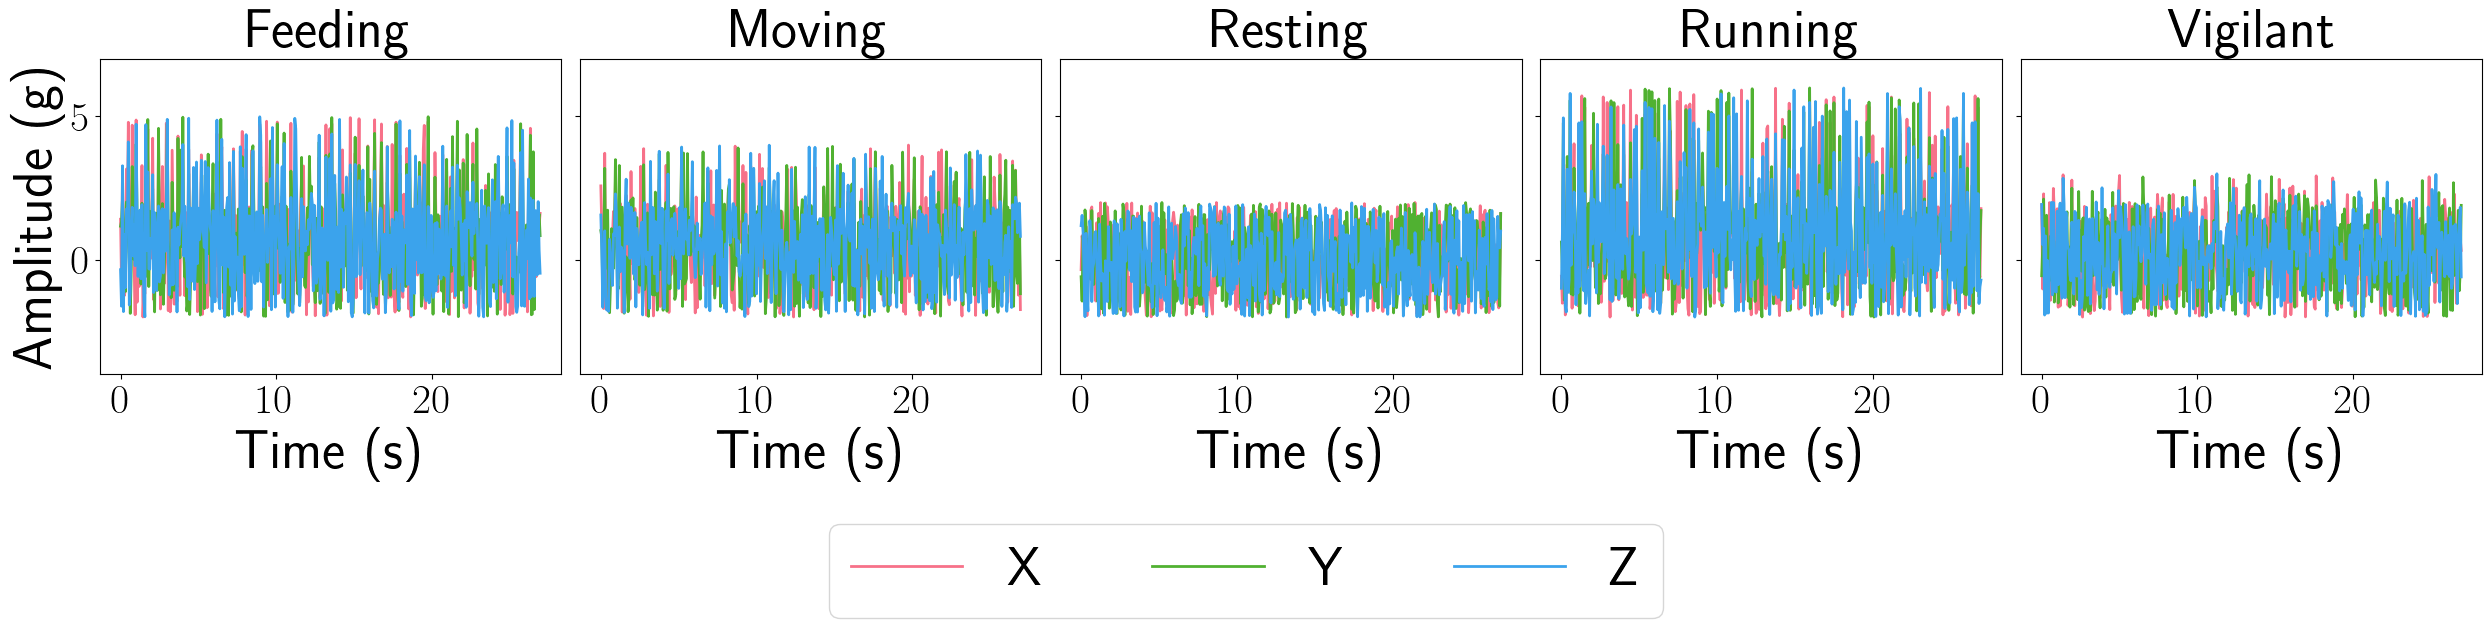

In [26]:
idx = [np.random.choice(np.where(y_test == i)[0]) for i in range(len(config.BEHAVIORS)) ]

colors = sns.color_palette('husl', 3)
fig, axs = plt.subplots(1, 5, figsize=(25, 5), sharey=True)

for n,i in enumerate(idx):
    with torch.no_grad():
        acc, target = torch.tensor(X_test[i], dtype=torch.float32), label_encoder.inverse_transform([y_test[i]])[0]
        logits, set = cmodel(acc.unsqueeze(0).to(device))
        logits_numpy = logits.detach().cpu().numpy()
        scores = softmax(logits_numpy, axis=1)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[0], color=colors[0], label='X', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[1], color=colors[1], label='Y', linewidth=2)
        axs[n].plot(np.arange(acc.shape[1])/16, acc[2], color=colors[2], label='Z', linewidth=2)
        axs[n].set_title(target)
        axs[n].set_ylim(-4, 7)
        axs[n].set_xlabel('Time (s)')
    print("")
    print(f'The true behavior is {target} and the RAPS is {label_encoder.inverse_transform(set[0])} with scores {scores[0][set[0]]}')
axs[0].set_ylabel('Amplitude (g)')
fig.tight_layout(pad=1.0)

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles=handles, labels=labels, loc='lower center',
        bbox_to_anchor=(0.5, -0.3), ncol=3)

plt.show()